# Life-Cycle Labor Supply with Children
### By Hans Christian Jul Lehmann

## Table of Contents:
* [Exercise 1: Event-Study Graph](#first-bullet)
    - [1A: Handheld Calibration](#firstA-bullet)
    - [1B: Structural Estimation](#firstB-bullet)
* [Exercise 2: Marshallian Elasticity](#second-bullet)
    - [Life Cycle Behavior](#secondA-bullet) 
    - [Marshallian Elasticities](#secondB-bullet) 
* [Exercise 3: Introducing a Spouse](#third-bullet)
* [Exercise 4: Introducing Childcare Costs](#fourth-bullet)
* [Exercise 6: Stochastic Fertility](#sixth-bullet)
    - [Life Cycle Behavior](#sixthA-bullet) 
    - [Marshallian Elasticities](#sixthB-bullet) 

# Setup

In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.optimize import minimize
import os
from scipy import optimize

# load local model file
from DynLaborFertModel import DynLaborFertModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercise 1: Event-Study Graph <a class="anchor" id="first-bullet"></a>

## 1.A: Handheld Calibration <a class="anchor" id="firstA-bullet"></a>

In [2]:
model = DynLaborFertModelClass(par={'spouse_rand':0.0,'theta':0.0,'y':0.0})

In [3]:
### initialize model class
model = DynLaborFertModelClass() 
model_bridge = DynLaborFertModelClass(par={'spouse_rand':0.0,'theta':0.0,'y':0.0,'beta_1':0.051})
model_true = DynLaborFertModelClass(par={'spouse_rand':0.0,'theta':0.0,'y':0.0,'beta_1':0.053})

In [4]:
models = [model, model_bridge, model_true]
# simulate and solve the instances for different values of beta_1
for model in models:
    model.solve()
    model.simulate()

In [47]:
# import local file
from DynLaborFertModel import event_study_graph

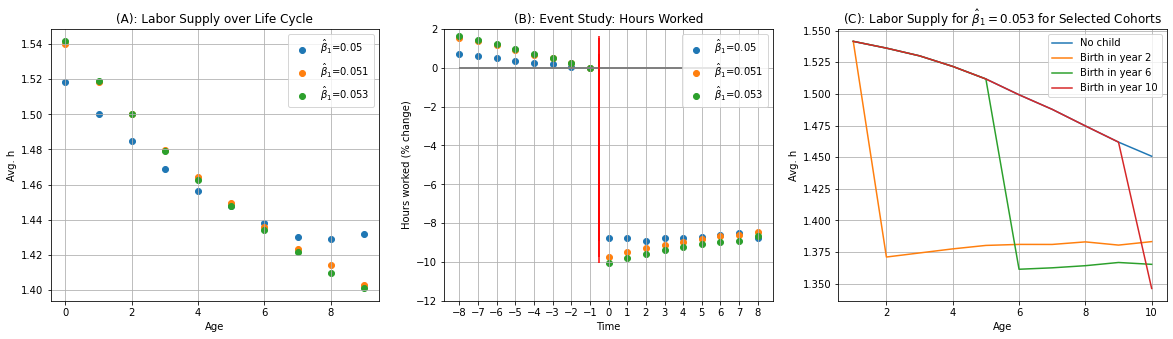

In [49]:
# create a list of beta_1 values for the legend
beta_1_values = [model.par.beta_1 for model in models]

# create the subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# plot the Hours graph (Subplot 1)
for model in models:
    axs[0].scatter(range(10), np.mean(getattr(model.sim, 'h'), axis=0), label=r'$\hat{\beta}_1$'+'='+str(model.par.beta_1))
    axs[0].legend(frameon=True)
    axs[0].set(xlabel='Age', ylabel='Avg. h')
    axs[0].set_title('(A): Labor Supply over Life Cycle')
axs[0].grid()

    
# Event-Study Graph (Subplot 2)
for model in models:
    model.simulate()
    axs[1] = event_study_graph(model, ax=axs[1])
axs[1].set(ylim=(-10, 1), yticks=range(-12, 3, 2), xlabel='Time', ylabel='Hours worked (% change)')
axs[1].set_title('(B): Event Study: Hours Worked')
axs[1].grid()


# For Selected Cohorts (Subplot 3)
axs[2].set_xlabel('Age')
I = model.sim.n[:,-1] == 0
birthyear = np.argmax(np.diff(model.sim.n), axis=1) + 1
birthyear[I] = 0
axs[2].plot(range(1, model_true.par.simT+1), model_true.sim.h[I].mean(axis=0), label='No child')

for year in range(1, model_true.par.simT+1, 4):
    axs[2].plot(range(1, model_true.par.simT+1), model_true.sim.h[birthyear == year].mean(axis=0), label=f'Birth in year {year+1}')

axs[2].set_ylabel('Avg. h')
axs[2].grid()
axs[2].legend()
axs[2].set_title('(C): Labor Supply for '+r'$\hat{\beta}_1=0.053$'+ ' for Selected Cohorts')

# adjust spacing between subplots and save the figure
plt.subplots_adjust(wspace=0.2)

if not os.path.exists("../plots"):
        os.makedirs("../plots")

plt.savefig("../plots/Handheldcalibration.pdf", bbox_inches='tight')

plt.show()

## 1.B: Structural Estimation <a class="anchor" id="firstB-bullet"></a>

Here, I perform a mock experiment of structural estimation by finding the $\beta_1$-value which minimizes the distance between the model prediction and the data moment. I will use a 10 percent drop in mean labor hours supplied the year of a birth as the data moment. 

In [ ]:
result = optimize.minimize(model.structural_est, x0=np.array([0.055]), method='Nelder-Mead', bounds = [(0.05, 0.055)], tol=1e-12)

# return "true" beta_1 value
true_beta_1 = result.x[0]

print("True beta_1 value:", true_beta_1)

# Exercise 2: Marshallian Elasticity <a class="anchor" id="second-bullet"></a>

Throughout the remainder of the notebook, I use $\beta_1 = 0.053$ as the default value.

## Life Cycle Behavior <a class="anchor" id="secondA-bullet"></a>

/var/folders/3j/22yv_sj10t96slp1b8b6z1zw0000gn/T/ipykernel_6796/2289112732.py:26: RuntimeWarning: Mean of empty slice
  mean_values = np.nanmean(np.where(condition, getattr(sim, var), np.nan), axis=0)


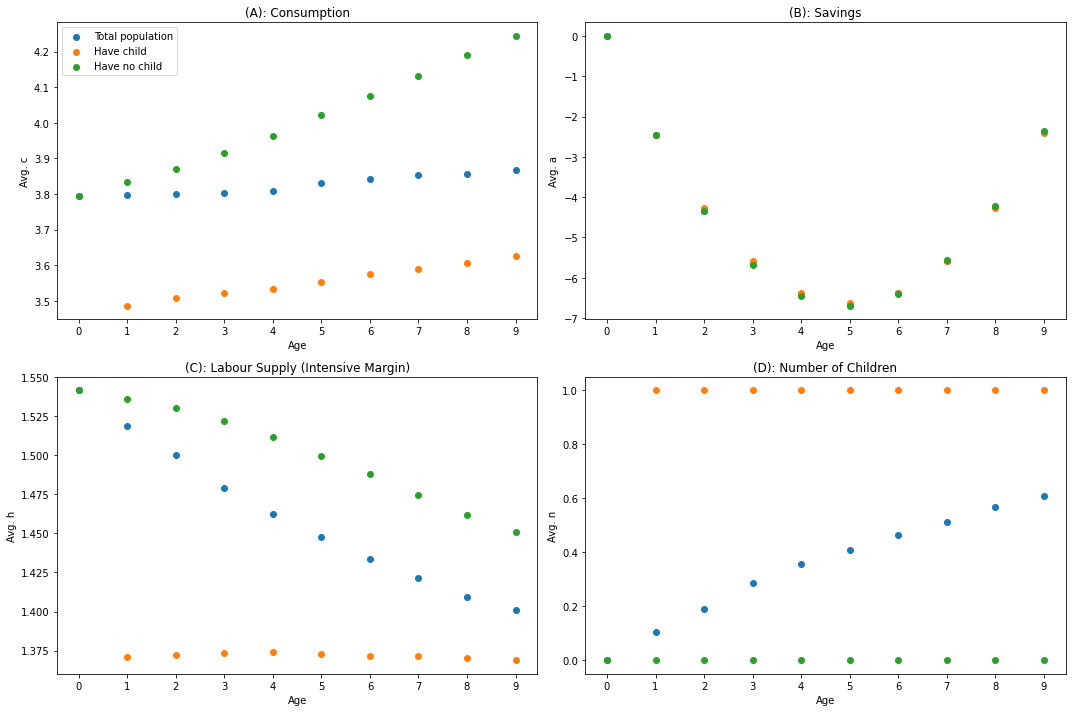

In [19]:
# Unpack parameters and simulation results
par = model_true.par
sim = model_true.sim

# Define conditions
total_population = np.ones(sim.n.shape, dtype=bool)
with_child = np.column_stack((np.zeros(sim.n.shape[0]), sim.n[:, 1:] > 0))
no_child = sim.n == 0

# Initialize a dictionary to store the axes for each plot
ax = {}

# Set up a 2x2 grid of subplots with a larger figure size
fig, ((ax['c'], ax['a']), (ax['h'], ax['n'])) = plt.subplots(2, 2, figsize=(15,10))

# Assign titles for each variable
titles = {'c': 'Consumption', 'a': 'Savings', 'h': 'Labour Supply (Intensive Margin)', 'n': 'Number of Children'}

# Assign panel letters for each variable
panel_letters = {'c': 'A', 'a': 'B', 'h': 'C', 'n': 'D'}

# Iterate over the keys of the dictionary, which correspond to the variables of interest
for var in ('c', 'a', 'h', 'n'):
    # Calculate the mean of the variable of interest under each condition
    for condition, label in zip((total_population, with_child, no_child), ('Total population', 'Have child', 'Have no child')):
        mean_values = np.nanmean(np.where(condition, getattr(sim, var), np.nan), axis=0)
        # Plot the mean values
        ax[var].scatter(range(par.simT), mean_values, label=label)

    # Set up the labels and ticks of the x-axis and y-axis
    ax[var].set(xlabel='Age', ylabel=f'Avg. {var}', xticks=range(par.simT))
    
    # Set the title for the subplot with the corresponding panel letter
    ax[var].set_title(f'({panel_letters[var]}): {titles[var]}')

    # If we are plotting consumption, add a legend to the plot
    if var == 'c':
        ax[var].legend()

# Ensure a clean layout

fig.tight_layout()

if not os.path.exists("../plots"):
        os.makedirs("../plots")
    
plt.savefig("../plots/LifeCycleBaseline.pdf", bbox_inches='tight')
plt.show()

## Marshallian Elasticities <a class="anchor" id="secondB-bullet"></a>

**Plot Marshallian Elasticity**

In [37]:
# import local file
from DynLaborFertModel import simulate_marshallian_elasticity

In [38]:
model_1pct, ela_total, ela_child, ela_no_child = simulate_marshallian_elasticity_subpopulations(model_true, 1.01)

Total Average Marshallian Elasticity: 0.022583
Average Marshallian Elasticity with child: 0.023351
Average Marshallian Elasticity without child: 0.021574


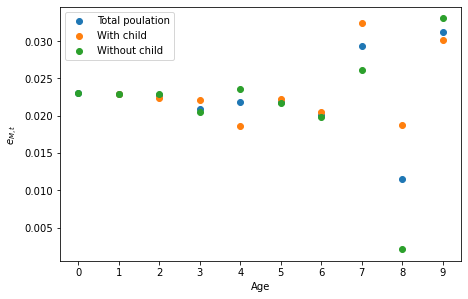

In [44]:
fig = plt.figure(figsize=(3*6, 3*6/1.5))

# plot Marshallian elasticity as a function of age for childless people in all periods
ax = fig.add_subplot(3, 3, 1)
ax.scatter(range(model_1pct.par.simT),np.mean(ela_total,axis=0),label='Total poulation') 
ax.scatter(range(model_1pct.par.simT),ela_child,label='With child') # do not plot first period since no births occur
ax.scatter(range(model_1pct.par.simT),ela_no_child,label='Without child') 
ax.set(xlabel='Age',ylabel='$e_{M,t}$',xticks=range(model.par.simT))
ax.legend(frameon=True);

# layout 
fig.tight_layout(pad=1); # spacing between subplots

if not os.path.exists("../plots"):
        os.makedirs("../plots")
    
plt.savefig("../plots/ElasticityBaseline.pdf", bbox_inches='tight')
plt.show()

# Exercise 3: Introducing a Spouse <a class="anchor" id="third-bullet"></a>

I introduce a spouse that contributes with the age-dependent wage process $(0.1+0.01\cdot t)$.

In [60]:
model_spouse = DynLaborFertModelClass(par={'spouse_rand':0.0,'theta':0.0,'beta_1':0.053,'y':1.0})
model_spouse.solve()
model_spouse.simulate()

Compute Marshallian elasticity:

In [61]:
model_1pct_spouse, ela_total_spouse = simulate_marshallian_elasticity(model_spouse, 1.01)

Total Average Marshallian Elasticity: 0.021559


Explore and compare simulated behavior in the presence and not in the presence of a spouse: 

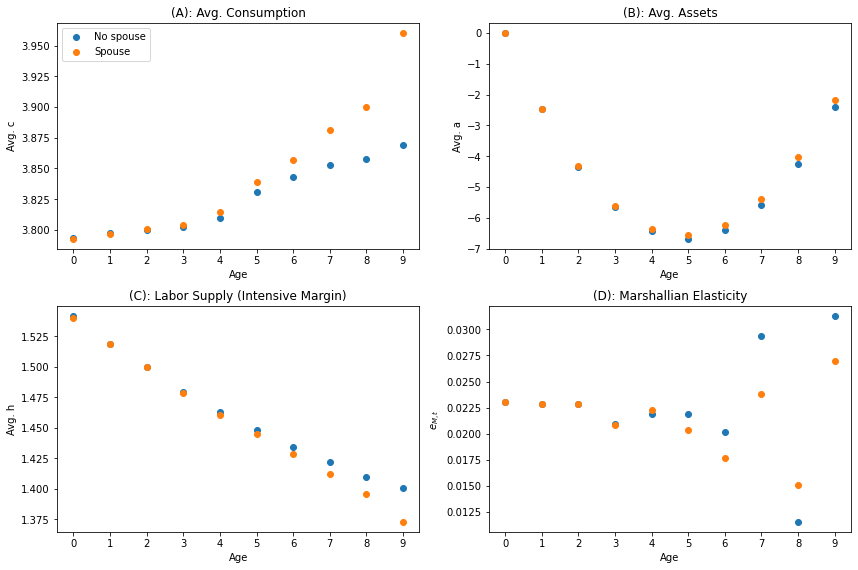

In [63]:
# create a figure with 4 subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# plot behavior
for var, ax in zip(('c', 'a', 'h'), axs.flatten()[:3]):
    ax.scatter(range(model_true.par.simT), np.mean(getattr(model_true.sim, var), axis=0), label='No spouse')
    ax.scatter(range(model_spouse.par.simT), np.mean(getattr(model_spouse.sim, var), axis=0), label='Spouse')
    ax.set(xlabel='Age', ylabel=f'Avg. {var}', xticks=range(10))

    # add subplot title
    if var == 'c':
        ax.set_title('(A): Avg. Consumption')
        ax.legend()
    elif var == 'a':
        ax.set_title('(B): Avg. Assets')
    elif var == 'h':
        ax.set_title('(C): Labor Supply (Intensive Margin)')

# plot Marshallian elasticity as a function of age
ax = axs.flatten()[3]
ax.scatter(range(model_true.par.simT), np.mean(ela_total, axis=0), label='No spouse')
ax.scatter(range(model_spouse.par.simT), np.mean(ela_total_spouse, axis=0), label='Spouse')
ax.set(xlabel='Age', ylabel='$e_{M,t}$', xticks=range(model_spouse.par.simT))
ax.set_title('(D): Marshallian Elasticity')

# layout
fig.tight_layout(pad=1)  # spacing between subplots

if not os.path.exists("../plots"):
        os.makedirs("../plots")
    
plt.savefig("../plots/SpouseLifeCycle.pdf", bbox_inches='tight')
plt.show()

# Exercise 4: Introducing Childcare Costs <a class="anchor" id="fourth-bullet"></a>

I introduce a childcare cost $\theta \cdot 0.05$.

In [64]:
model_spouse_childcarecost = DynLaborFertModelClass(par={'spouse_rand':0.0,'beta_1':0.053,'theta':0.05,'y':1.0})
model_spouse_childcarecost.solve()
model_spouse_childcarecost.simulate()

Compute Marshallian elasticity:

In [65]:
model_1pct_spouse_childcarecost, ela_total_spouse_childcarecost = simulate_marshallian_elasticity(model_spouse_childcarecost, 1.01)

Total Average Marshallian Elasticity: 0.021377


Explore and compare simulated behavior with and without childcare costs: 

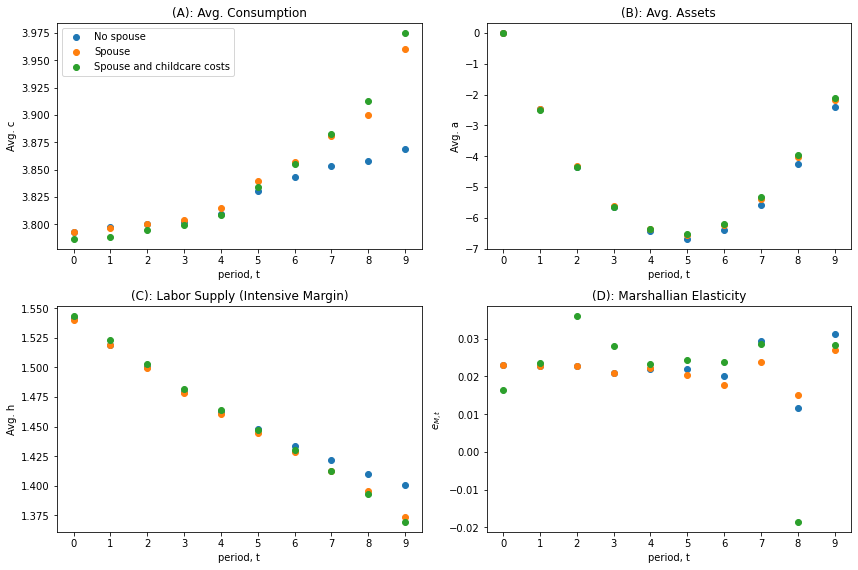

In [67]:
# create a figure with 4 subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# plot behavior
for var, ax in zip(('c', 'a', 'h'), axs.flatten()[:3]):
    ax.scatter(range(model_true.par.simT), np.mean(getattr(model_true.sim, var), axis=0), label='No spouse')
    ax.scatter(range(model_spouse.par.simT), np.mean(getattr(model_spouse.sim, var), axis=0), label='Spouse')
    ax.scatter(range(model_spouse_childcarecost.par.simT), np.mean(getattr(model_spouse_childcarecost.sim, var), axis=0), label='Spouse and childcare costs')
    ax.set(xlabel='Age', ylabel=f'Avg. {var}', xticks=range(10))

    # add subplot title
    if var == 'c':
        ax.set_title('(A): Avg. Consumption')
        ax.legend()
    elif var == 'a':
        ax.set_title('(B): Avg. Assets')
    elif var == 'h':
        ax.set_title('(C): Labor Supply (Intensive Margin)')

# plot Marshallian elasticity as a function of age
ax = axs.flatten()[3]
ax.scatter(range(model_true.par.simT), np.mean(ela_total, axis=0), label='No spouse')
ax.scatter(range(model_spouse.par.simT), np.mean(ela_total_spouse, axis=0), label='Spouse')
ax.scatter(range(model_spouse_childcarecost.par.simT), np.mean(ela_total_spouse_childcarecost, axis=0), label='Spouse')
ax.set(xlabel='period, t', ylabel='$e_{M,t}$', xticks=range(model_spouse.par.simT))
ax.set_title('(D): Marshallian Elasticity')

# layout
fig.tight_layout(pad=1)  # spacing between subplots

if not os.path.exists("../plots"):
        os.makedirs("../plots")
    
plt.savefig("../plots/SpouseandCCCLifeCycle.pdf", bbox_inches='tight')
plt.show()

# Exercise 6: Stochastic Fertility <a class="anchor" id="sixth-bullet"></a>

Lastly, I extend the model with a state variable $s_{t} \in \{0,1\}$ where likelihood of spouse being $p_{s}=0.8$. Furthermore, let the arrival of children depend on presence of spouse in a given period.

In [87]:
model_spouse_rand = DynLaborFertModelClass(par={'spouse_rand':1.0,'theta':0.05,'beta_1':0.053,'y':1.0,'p_spouse':0.8})
model_spouse_rand.solve()
model_spouse_rand.simulate()

Compute Marshallian elasticity:

In [88]:
model_1pct_rand, ela_total_rand = simulate_marshallian_elasticity(model_spouse_rand, 1.01)

Total Average Marshallian Elasticity: 0.022208


## Life Cycle Behavior <a class="anchor" id="sixthA-bullet"></a>

Explore and compare simulated behavior with a deterministic or stochastic presence of spouse:

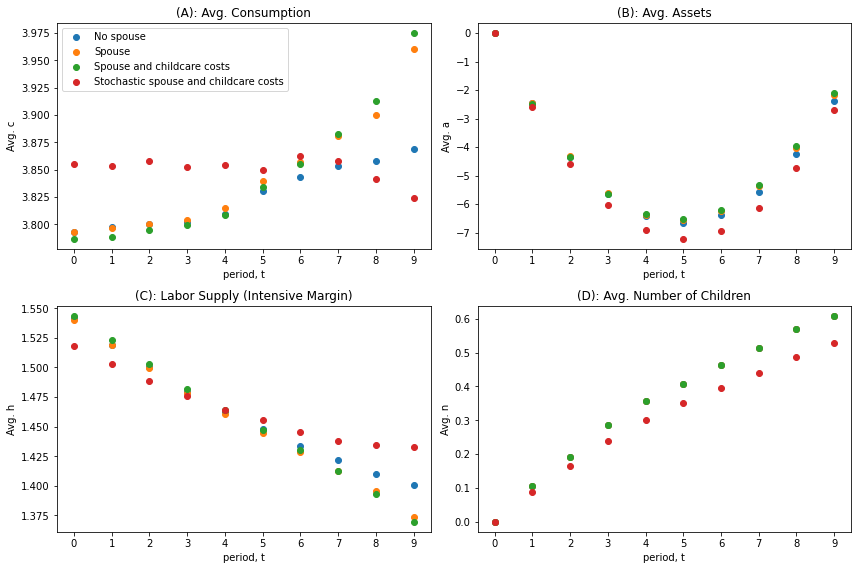

In [89]:
# create a figure with 4 subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# plot behavior
for var, ax in zip(('c', 'a', 'h','n'), axs.flatten()):
    ax.scatter(range(model_true.par.simT), np.mean(getattr(model_true.sim, var), axis=0), label='No spouse')
    ax.scatter(range(model_spouse.par.simT), np.mean(getattr(model_spouse.sim, var), axis=0), label='Spouse')
    ax.scatter(range(model_spouse_childcarecost.par.simT), np.mean(getattr(model_spouse_childcarecost.sim, var), axis=0), label='Spouse and childcare costs')
    ax.scatter(range(model_spouse_rand.par.simT), np.mean(getattr(model_spouse_rand.sim, var), axis=0), label='Stochastic spouse and childcare costs')
    ax.set(xlabel='Age', ylabel=f'Avg. {var}', xticks=range(10))

    # add subplot title
    if var == 'c':
        ax.set_title('(A): Avg. Consumption')
        ax.legend()  
    elif var == 'a':
        ax.set_title('(B): Avg. Assets')
    elif var == 'h':
        ax.set_title('(C): Labor Supply (Intensive Margin)')
    elif var == 'n':
        ax.set_title('(D): Avg. Number of Children')

# layout
fig.tight_layout(pad=1)  # spacing between subplots

if not os.path.exists("../plots"):
        os.makedirs("../plots")
    
plt.savefig("../plots/RandomSpouseLifeCycle.pdf", bbox_inches='tight')
plt.show()

## Marshallian Elasticities <a class="anchor" id="sixthB-bullet"></a>

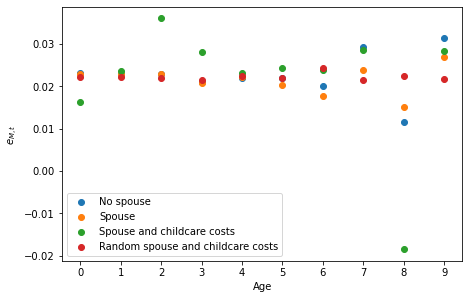

In [90]:
fig = plt.figure(figsize=(3*6, 3*6/1.5))

# plot Marshallian elasticity as a function of age for childless people in all periods
ax = fig.add_subplot(3, 3, 1)
ax.scatter(range(model_1pct.par.simT),np.mean(ela_total,axis=0),label='No spouse') 
ax.scatter(range(model_1pct_spouse.par.simT),np.mean(ela_total_spouse,axis=0),label='Spouse') 
ax.scatter(range(model_1pct_spouse_childcarecost.par.simT),np.mean(ela_total_spouse_childcarecost,axis=0),label='Spouse and childcare costs') 
ax.scatter(range(model_1pct_rand.par.simT),np.mean(ela_total_rand,axis=0),label='Random spouse and childcare costs') 
ax.set(xlabel='Age',ylabel='$e_{M,t}$',xticks=range(model.par.simT))
ax.legend(frameon=True);

# layout 
fig.tight_layout(pad=1); # spacing between 

if not os.path.exists("../plots"):
        os.makedirs("../plots")
    
plt.savefig("../plots/RandomSpouseElasticity.pdf", bbox_inches='tight')
plt.show()